In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

In [2]:
import pickle
import json

In [3]:
def plot_grs(*gr, start=0, end=-1, log = False, all_ticks = False,  s=10):
    f, a = plt.subplots(1, len(gr), figsize=(s,s))

    if end == -1:
        end = gr[0].shape[0]
    if log:
        for i in range(len(gr)): 
            a[i].imshow(np.log(gr[i][start:end,start:end] + 1))
    else:
        for i in range(len(gr)): 
            a[i].imshow(gr[i][start:end,start:end])
            #a[i].colorbar()
#     if all_ticks: 
#         plt.xticks(np.arange(start,end))
#         plt.yticks(np.arange(start,end))
    plt.show()

In [4]:
def plot_gr(gr, start=0, end=-1, log = False, all_ticks = False,  s=10):
    plt.figure(figsize=(s,s))
    if end == -1:
        end = gr.shape[0]
    if log:
        plt.imshow(np.log(gr[start:end,start:end] + 1))
    else:
        plt.imshow(gr[start:end,start:end])
    plt.colorbar()
    if all_ticks: 
        plt.xticks(np.arange(start,end))
        plt.yticks(np.arange(start,end))
    plt.show()

In [5]:
from nltk import ngrams

In [6]:
np.random.binomial(1, 0.5, 10)

array([0, 1, 0, 1, 1, 0, 0, 1, 0, 0])

In [7]:
SWITCH_PROB = 0.2
AMPLIFY_PROB = 1.
STOP_PROB = 0
MAX_LEN = 5

In [8]:
MAX_LEN = 6
population = np.ones((3,MAX_LEN + 1)) * -1
population[0,0:6] = np.arange(0,6)
population[0,0] = 0
population[1,0:6] = np.arange(6,12)
population[1,0] = 1
population[2,0:6] = np.arange(12,18)
population[2,0] = 2
population

array([[ 0.,  1.,  2.,  3.,  4.,  5., -1.],
       [ 1.,  7.,  8.,  9., 10., 11., -1.],
       [ 2., 13., 14., 15., 16., 17., -1.]])

In [9]:
population_f = population.copy()
population_b = reverse_population(population_f)

NameError: name 'reverse_population' is not defined

In [ ]:
single_amplify(population_f, np.ones(3), 1,1)

In [ ]:
population_f

In [ ]:
population_b

In [ ]:
population_f, population_b = PCR_cycle(population_f, population_b, np.array([1,1,1]))

In [25]:
def reverse_population(p):
    p_b = p.copy()
    for i in range(p.shape[0]):
        length = (p[i] != -1).sum() - 1
        
        p_b[i,1:length + 1] = p[i,1:length + 1][::-1]
    return p_b

In [10]:
def generate_initial_population(spacers_num, chain_number=2, max_amount_per_chain = 2, min_len = 4, v = False):
    # markov is our god! 
    graph = np.zeros((spacers_num, spacers_num))
    for i in range(spacers_num):
        for j in range(spacers_num -1, i, -1):
            graph[i,j] = spacers_num - j

    if v:
        plot_gr(graph)
        
    graph /= np.max(np.vstack((graph.sum(1), np.ones(spacers_num))), 0).reshape(-1,1)
    all_chains = []
    while len(all_chains) < chain_number:
        chain = []
        amount = np.random.randint(1, max_amount_per_chain)
        max_len = max([np.random.randint(min_len,spacers_num + 1) for i in range(3)])
        curr = np.random.randint(0, (spacers_num - 1) / 2 )

        for j in range(max_len):
            chain.append(curr)
            if curr != spacers_num - 1:
                #print(np.arange(spacers_num), graph[curr])
                curr = np.random.choice(np.arange(spacers_num), 1, p = graph[curr])[0]
            else:
                break
        
        if len(chain) > min_len:
            all_chains.extend([chain for k in range(amount)])
    
    return all_chains[:chain_number]

In [11]:
def population_from_list_of_lists(list_of_lists, cassettes_types = None, multiplier = 1):
    max_len = max([len(x) for x in list_of_lists])
    population_f = np.ones((len(list_of_lists), max_len + 1)) * (-1)
    population_b = np.ones((len(list_of_lists), max_len + 1)) * (-1)
    for i,l in enumerate(list_of_lists):
        population_f[i, 1:len(l) + 1] = np.array(l)
        population_b[i, 1:len(l) + 1] = np.array(l[::-1])
        
    if cassettes_types is not None:
        population_f[:,0],population_b[:,0] = [np.array(cassettes_types)]*2
        
    else:
        population_f[:,0],population_b[:,0] = [0]*2
    
    if multiplier > 1:
        population_f = np.vstack([population_f] * multiplier)
        population_b = np.vstack([population_b] * multiplier)
    return population_f, population_b, max_len
        

In [12]:
np.random.randint(1,3,10)

array([2, 2, 2, 1, 1, 1, 1, 2, 2, 1])

In [13]:
## LEGACY
#         # START BY RANDOM FROM BEGGINING
#         to_start = False
#         start = 0
#         while not to_start and start < source_len:
#             start += 1
#             if np.random.random() < START_PROB:
#                 to_start = True
#         if v: print("start : ", start)


In [17]:
def single_amplify(all_population, switch_weights, amplify_prob, v = False): 
    #mask = np.random.binomial(1, amplify_prob, all_population.shape[0]).astype(bool)
    mask = all_population[:, 0] == 0 
    population_to_amplify = all_population[mask] 
    new = np.ones((population_to_amplify.shape[0], MAX_LEN + 1)) * (-1)
    
    if v:
        print(mask)
        print(population_to_amplify)
    
    i = 0
    for chain in population_to_amplify:
        source_len = (chain != -1).sum() - 1 

        if v: print("source len:", source_len)
              
        start = np.random.randint(1, source_len + 1 - 1)
        stop = False
#        end = np.random.randint(start + 1, source_len + 1)
        pointer_new = 1
        pointer_source = start
        
        new[i,0] = 0
        
        while not stop:            
            new[i,pointer_new] = chain[pointer_source]
            
            pointer_new += 1
            pointer_source += 1
            
            if pointer_source == source_len + 1:
                switch_prob = SWITCH_PROB / 10
            else:
                switch_prob = SWITCH_PROB
            switch = np.random.rand() < switch_prob
            
            if v:
                print(chain, new[i], switch)
            if switch:
                new[i,0] = 1
                mask = np.zeros(1)
                while mask.sum() ==0:
                    chain_type = np.random.choice(np.arange(switch_weights.shape[0]), p = switch_weights / switch_weights.sum())
                    mask = population_to_amplify[:, 0] == chain_type
                chain = population_to_amplify[mask][np.random.randint(0, mask.sum())]
                source_len = (chain != -1).sum() - 1 
                pointer_source = np.random.randint(1, source_len)
#                 chain = all_population[np.random.randint(0, all_population.shape[0])]
#                 source_len = (chain != -1).sum() - 1 
#                 pointer_source = np.random.randint(1, source_len)

            if np.random.rand() < STOP_PROB:
                stop = True
            if pointer_new == new.shape[1]:
                stop = True

            if pointer_source == source_len + 1:
                stop = True
#                 if np.random.rand() < SWITCH_PROB :
#                     mask = np.zeros(1)
#                     while mask.sum() ==0:
#                         chain_type = np.random.choice(np.arange(switch_weights.shape[0]), p = switch_weights / switch_weights.sum())
#                         mask = population_to_amplify[:, 0] == chain_type

#                     chain = population_to_amplify[mask][np.random.randint(0, mask.sum())]
#                     source_len = (chain != -1).sum() - 1 
#                     pointer_source = np.random.randint(1, source_len)
#                 else:
#                     stop = True
            
            if v:
                print(chain, new[i], switch)

        if (new[i] != -1).sum() > 2:
            i += 1
        
    
    return new[(new != -1).sum(1) > 2 ]
    
     

In [18]:
def PCR_cycle(population_f, population_b, switch_weights):       
    new_f = single_amplify(population_f, switch_weights, AMPLIFY_PROB_F)
    new_b = single_amplify(population_b, switch_weights, AMPLIFY_PROB_B)
    
    population_f = np.vstack((population_f, reverse_population(new_b)))
    population_b = np.vstack((population_b, reverse_population(new_f)))
    
    return population_f, population_b

In [19]:
def pairs_to_graph(pairs, spacers_n):
    gr = np.zeros((spacers_n, spacers_n))
    
    for p in pairs:
        gr[int(p[0]), int(p[1])] += 1
        
    return gr

In [48]:
SWITCH_PROB = 0.16
AMPLIFY_PROB_F = 0.2
AMPLIFY_PROB_B = 0.9
STOP_PROB = 0.0
START_PROB = 0.85

In [49]:
population_as_list = [[1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16] for i in range(10)] + \
               [[4, 2, 5, 7, 11] for i in range(10)] + \
               [[4, 24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34]] + \
               [[1, 20, 22, 23, 21, 29]]

pairs_1 = set([x for y in population_as_list[:10] for x in ngrams(y, 2)])
pairs_2 = set([x for y in population_as_list[10:] for x in ngrams(y, 2)])

In [50]:
all_ratios_plots = []

In [51]:
population_f, population_b, MAX_LEN = population_from_list_of_lists(population_as_list, [0]*20 + [0]*2, 1)

A Jupyter Widget

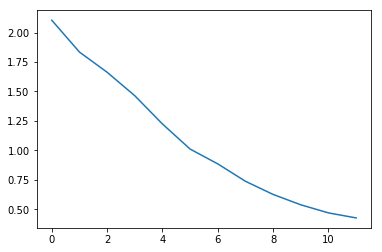

In [52]:
population_ratio = []

for i in tqdm_notebook(range(50)) :
    all_pairs = []
    for seq in np.vstack((population_f,reverse_population(population_b))):
        seq = seq[seq != -1][1:]
        for x in ngrams(seq,2):
            all_pairs.append(x)
            
    cp_1, cp_2, cp_3 = 0,0,0
    for p in all_pairs:
        if p in pairs_1:
            cp_1+=1
        elif p in pairs_2:
            cp_2+=1
        else:
            cp_3+=1

    population_ratio.append(cp_1 / cp_2)
    
    population_f, population_b = PCR_cycle(population_f, population_b, np.array([1,1]))

    if population_f.shape[0] > 15000:
        break

all_ratios_plots.append(population_ratio)

for p_r in all_ratios_plots:
    plt.plot(p_r)
plt.show()

In [53]:
gr = pairs_to_graph(all_pairs, 35)

In [54]:
tr_gr_3 = np.load("../../data/graphs/ES3_22.npy")[:35,:35].astype(int)
tr_gr_4 = np.load("../../data/graphs/ES4_22.npy")[:35,:35].astype(int)

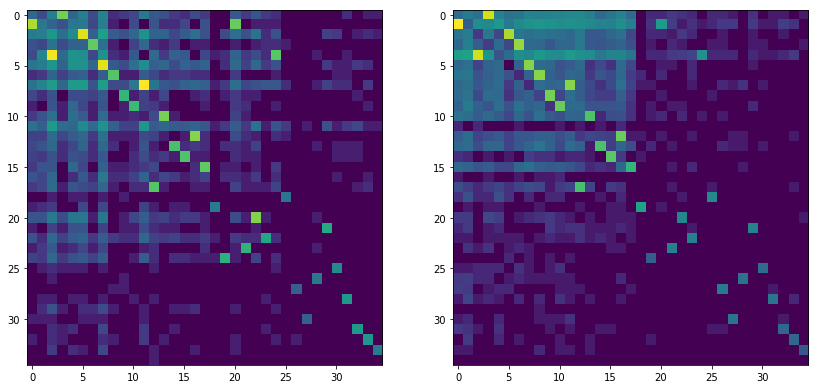

In [55]:
plot_grs(gr, tr_gr_3, s = 14, log=1)

In [213]:
population_as_list

[[1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [1, 0, 3, 6, 8, 9, 

<Container object of 35 artists>

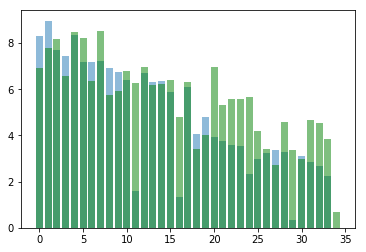

In [56]:
plt.bar(np.arange(35), np.log(tr_gr_3.sum(1) * gr.sum() / tr_gr_3.sum() + 1), alpha = 0.5)
plt.bar(np.arange(35), np.log(gr.sum(1) + 1), alpha = 0.5, color = 'g')

NameError: name 'gr_1' is not defined

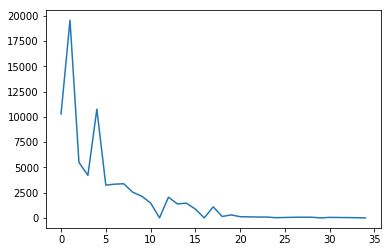

In [187]:
plt.plot((tr_gr_3.sum(1) + 1))
plt.plot((gr_1.sum(1) + 1))

In [77]:
np.array([[0,1]]).sum(1)

array([1])